In [1]:
import time

from six import iteritems
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

from nilmtk.utils import print_dict
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import seaborn as sns

rcParams['figure.figsize'] = (8, 5)
rcParams['figure.dpi'] = 150
plt.style.use('seaborn-whitegrid')
sns.set_palette("muted")

c:\users\chuan\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
c:\users\chuan\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
top_k = 6

train = DataSet("./AMPD/AMPds.h5")

# set start and end date
start_date = "2012-04-01"
end_date = "2012-04-08"

train.set_window(start=start_date, end=end_date)

In [3]:
test = DataSet("./AMPD/AMPds.h5")

# set start and end date
start_date = "2012-04-09"
end_date = "2012-04-10"

test.set_window(start=start_date, end=end_date)

In [4]:
train_elec = train.buildings[1].elec.select_top_k(k=top_k)
test_elec = test.buildings[1].elec.select_top_k(k=top_k)

3/21 ElecMeter(instance=3, building=1, dataset='AMPds', appliances=[Appliance(type='light', instance=2)])

c:\users\chuan\appdata\local\programs\python\python36\lib\site-packages\pandas\core\series.py:1152: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


21/21 ElecMeter(instance=21, building=1, dataset='AMPds', appliances=[Appliance(type='electric oven', instance=1)])

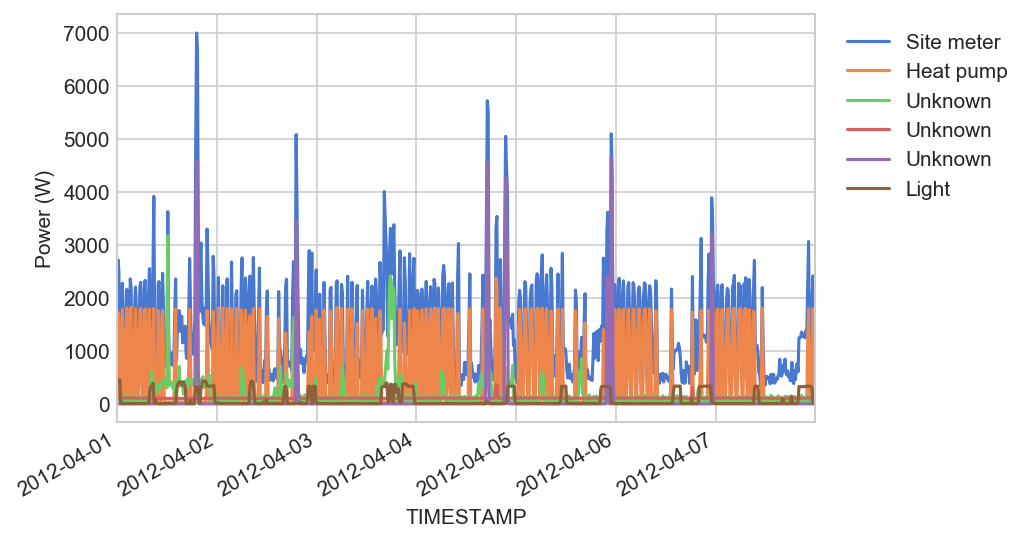

In [5]:
fig = plt.figure(dpi=150)
train_elec.plot()
plt.legend(bbox_to_anchor=(1.02, 1), loc=2)

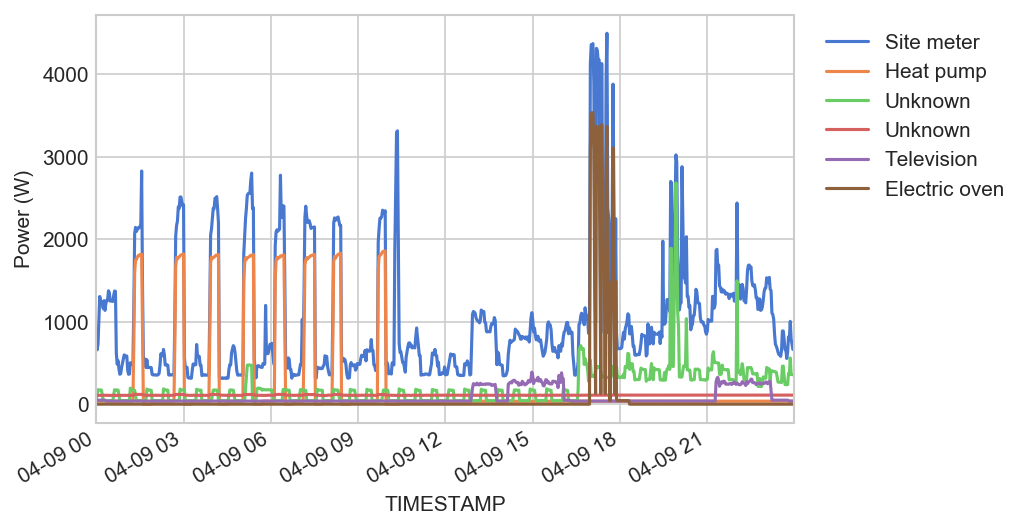

In [6]:
fig = plt.figure(dpi=150)
test_elec.plot()
plt.legend(bbox_to_anchor=(1.02, 1), loc=2)

# รูปแบบ ของ classifier

In [7]:
classifiers = {'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}

## Training and disaggregation
### A function to disaggregate the mains data to constituent appliances and return the predictions

In [8]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'apparent', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

#     # Having the same order of columns
#     print(pred_overall)
#     gt_overall = gt_overall[pred_overall.columns]
    
#     #Intersection of index
#     gt_index_utc = gt_overall.index.tz_convert("UTC")
#     pred_index_utc = pred_overall.index.tz_convert("UTC")
#     common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
#     common_index_local = common_index_utc.tz_convert(timezone)
#     gt_overall = gt_overall.loc[common_index_local]
#     pred_overall = pred_overall.loc[common_index_local]
#     appliance_labels = [m for m in gt_overall.columns.values]
#     gt_overall.columns = appliance_labels
#     pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

In [9]:
sample_period = 60
predictions = {}
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    start = time.time()
    # Note that we have given the sample period to downsample the data to 1 minute. 
    # If instead of top_5 we wanted to train on all appliance, we would write 
    # fhmm.train(train_elec, sample_period=60)
    clf.train(train_elec, sample_period=sample_period)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])

********************
CO
********************
Training model for submeter 'ElecMeter(instance=14, building=1, dataset='AMPds', appliances=[Appliance(type='heat pump', instance=1)])'


c:\users\chuan\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\users\chuan\appdata\local\programs\python\python36\lib\site-packages\sklearn\cluster\k_means_.py:625: RuntimeWarning: invalid value encountered in multiply
  inertia = (mindist * sample_weight).sum()


Training model for submeter 'ElecMeter(instance=18, building=1, dataset='AMPds', appliances=[Appliance(type='unknown', instance=9)])'
Training model for submeter 'ElecMeter(instance=12, building=1, dataset='AMPds', appliances=[Appliance(type='unknown', instance=6)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='AMPds', appliances=[Appliance(type='unknown', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='AMPds', appliances=[Appliance(type='light', instance=3)])'
Done training!
Runtime = 0.8821954727172852 seconds.
Estimating power demand for 'ElecMeter(instance=14, building=1, dataset='AMPds', appliances=[Appliance(type='heat pump', instance=1)])'
Estimating power demand for 'ElecMeter(instance=18, building=1, dataset='AMPds', appliances=[Appliance(type='unknown', instance=9)])'
Estimating power demand for 'ElecMeter(instance=12, building=1, dataset='AMPds', appliances=[Appliance(type='unknown', instance=6)])'
Estimating 

In [32]:
method = 'CO'

In [33]:
gt.head()

ElecMeter(instance=14, building=1, dataset='AMPds', appliances=[Appliance(type='heat pump', instance=1)])  \
TIMESTAMP                                                                                                                              
2012-04-09 00:00:00-07:00                                               36.0                                                           
2012-04-09 00:01:00-07:00                                               37.0                                                           
2012-04-09 00:02:00-07:00                                               37.0                                                           
2012-04-09 00:03:00-07:00                                               37.0                                                           
2012-04-09 00:04:00-07:00                                               37.0                                                           

                           ElecMeter(instance=18, building=1, dataset='AMPds', appliances=[Appliance(type='unknown', instance=9)])  \
TIMESTAMP                                                                                                                            
2012-04-09 00:00:00-07:00                                               43.0                                                         
2012-04-09 00:01:00-07:00                                               43.0                                                         
2012-04-09 00:02:00-07:00                                               43.0                                                         
2012-04-09 00:03:00-07:00                                              194.0                                                         
2012-04-09 00:04:00-07:00                                              178.0                                                         

                           ElecMeter(instance=12, building=1, dataset='AMPds', appliances=[Appliance(type='unknown', instance=6)])  \
TIMESTAMP                                                                                                                            
2012-04-09 00:00:00-07:00                                              107.0                                                         
2012-04-09 00:01:00-07:00                                              107.0                                                         
2012-04-09 00:02:00-07:00                                              107.0                                                         
2012-04-09 00:03:00-07:00                                              107.0                                                         
2012-04-09 00:04:00-07:00                                              108.0                                                         

                           ElecMeter(instance=19, building=1, dataset='AMPds', appliances=[Appliance(type='television', instance=1)])  \
TIMESTAMP                                                                                                                               
2012-04-09 00:00:00-07:00                                               48.0                                                            
2012-04-09 00:01:00-07:00                                               48.0                                                            
2012-04-09 00:02:00-07:00                                               48.0                                                            
2012-04-09 00:03:00-07:00                                               48.0                                                            
2012-04-09 00:04:00-07:00                                               48.0                                                            

                           ElecMeter(instance=21, building=1, dataset='AMPds', appliances=[Appliance(type='electric oven', instance=1)])  
TIMESTAMP                                                                                        

In [34]:
predictions[method].head()

ElecMeter(instance=14, building=1, dataset='AMPds', appliances=[Appliance(type='heat pump', instance=1)])  \
TIMESTAMP                                                                                                                              
2012-04-09 00:00:00-07:00                                               37.0                                                           
2012-04-09 00:01:00-07:00                                               37.0                                                           
2012-04-09 00:02:00-07:00                                               37.0                                                           
2012-04-09 00:03:00-07:00                                               37.0                                                           
2012-04-09 00:04:00-07:00                                                0.0                                                           

                           ElecMeter(instance=18, building=1, dataset='AMPds', appliances=[Appliance(type='unknown', instance=9)])  \
TIMESTAMP                                                                                                                            
2012-04-09 00:00:00-07:00                                                0.0                                                         
2012-04-09 00:01:00-07:00                                                0.0                                                         
2012-04-09 00:02:00-07:00                                                0.0                                                         
2012-04-09 00:03:00-07:00                                              148.0                                                         
2012-04-09 00:04:00-07:00                                              148.0                                                         

                           ElecMeter(instance=12, building=1, dataset='AMPds', appliances=[Appliance(type='unknown', instance=6)])  \
TIMESTAMP                                                                                                                            
2012-04-09 00:00:00-07:00                                              366.0                                                         
2012-04-09 00:01:00-07:00                                              108.0                                                         
2012-04-09 00:02:00-07:00                                              108.0                                                         
2012-04-09 00:03:00-07:00                                              366.0                                                         
2012-04-09 00:04:00-07:00                                              366.0                                                         

                           ElecMeter(instance=5, building=1, dataset='AMPds', appliances=[Appliance(type='unknown', instance=1)])  \
TIMESTAMP                                                                                                                           
2012-04-09 00:00:00-07:00                                              243.0                                                        
2012-04-09 00:01:00-07:00                                              243.0                                                        
2012-04-09 00:02:00-07:00                                              243.0                                                        
2012-04-09 00:03:00-07:00                                              243.0                                                        
2012-04-09 00:04:00-07:00                                              243.0                                                        

                           ElecMeter(instance=4, building=1, dataset='AMPds', appliances=[Appliance(type='light', instance=3)])  
TIMESTAMP                                                                                                                        
2012

In [35]:
fig = plt.figure(figsize=(9, 5), dpi=150)
plt.plot(predictions[method].iloc[:, 0], label='predict (disaggregate)')
test_elec[14].plot()
test_elec[1].plot()
plt.legend(bbox_to_anchor=(1.02, 1), loc=2)

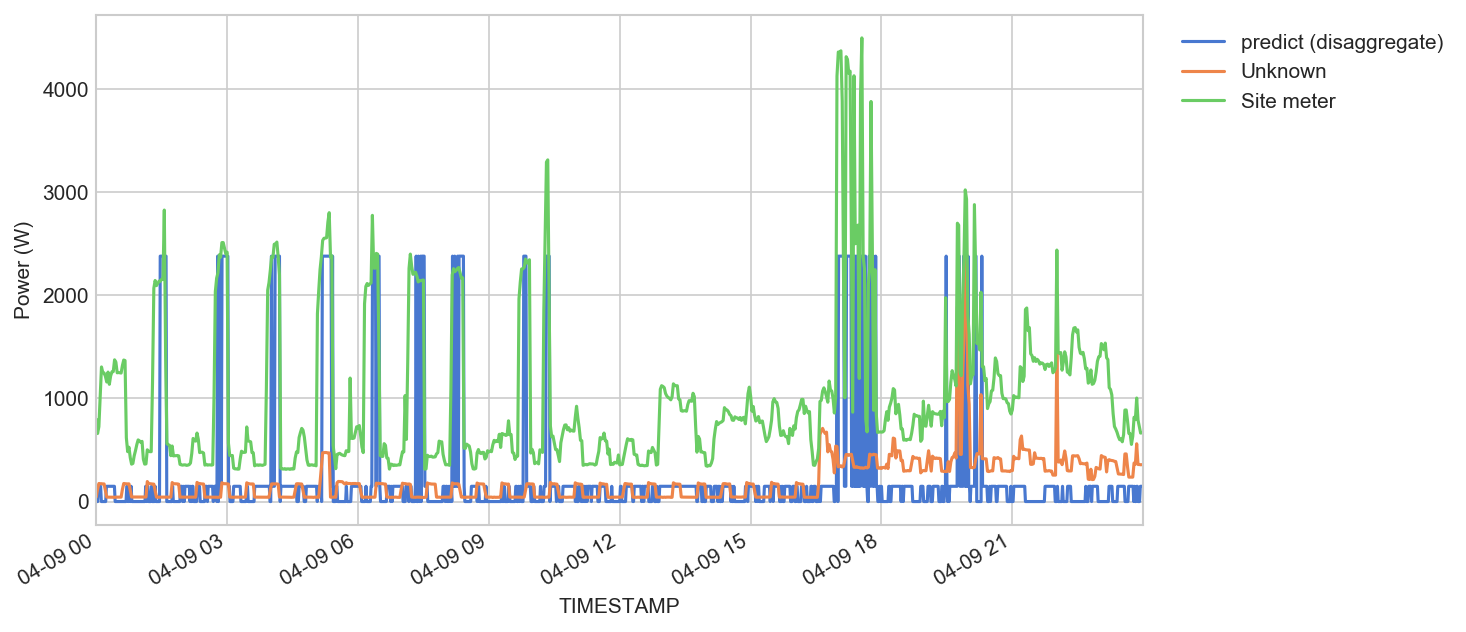

In [36]:
fig = plt.figure(figsize=(9, 5), dpi=150)
plt.plot(predictions[method].iloc[:, 1], label='predict (disaggregate)')
test_elec[18].plot()
test_elec[1].plot()
plt.legend(bbox_to_anchor=(1.02, 1), loc=2)